In [216]:
import numpy as np
import matplotlib.pyplot as plt

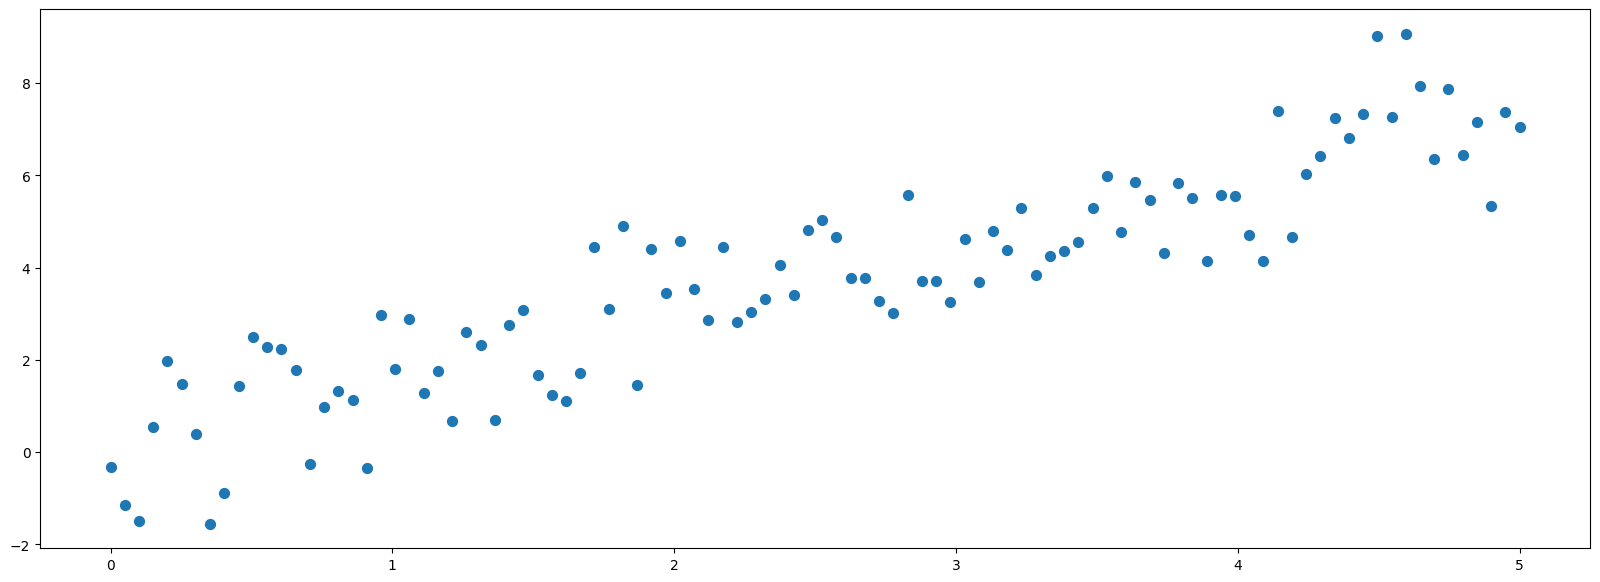

In [217]:
x1 = np.linspace(0, 5, 100)
x2 = np.linspace(0, 5, 100)

X = np.column_stack((x1, x2))

# y = x1**2 + x2 + 1.5 * np.random.randn(100)

Y =   3*X[:, 0] -1.5 * X[:, 1] +  np.random.randn(100)

plt.figure(figsize=(20, 7))
plt.scatter(X[:, 0], Y, s=50)
plt.show()

In [218]:
import numpy as np

class Tensor:
    def __init__(self, data, _children=(), _op=''):
        self.data = data if isinstance(data, np.ndarray) else np.array(data)
        self.grad = np.zeros_like(self.data)
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            grad_self = Tensor._match_shape(out.grad, self.data.shape)
            grad_other = Tensor._match_shape(out.grad, other.data.shape)
            self.grad += grad_self
            other.grad += grad_other

        out._backward = _backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data - other.data, (self, other), '-')

        def _backward():
            grad_self = Tensor._match_shape(out.grad, self.data.shape)
            grad_other = Tensor._match_shape(out.grad, other.data.shape)
            self.grad += grad_self
            other.grad -= grad_other

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, (self, other), '*')

        def _backward():
            grad_self = Tensor._match_shape(other.data * out.grad, self.data.shape)
            grad_other = Tensor._match_shape(self.data * out.grad, other.data.shape)
            self.grad += grad_self
            other.grad += grad_other

        out._backward = _backward
        return out

    def __matmul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data @ other.data, (self, other), '@')

        def _backward():
            self.grad += out.grad @ other.data.T
            other.grad += self.data.T @ out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(t):
            if t not in visited:
                visited.add(t)
                for child in t._prev:
                    build_topo(child)
                topo.append(t)

        build_topo(self)
        self.grad = np.ones_like(self.data)

        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Tensor(data={self.data}, shape={self.data.shape})"

    @staticmethod
    def _match_shape(grad, shape):
        """
        Reduce el gradiente para que coincida con la forma del tensor original.
        `shape` debe ser una tupla, como (100, 1), etc.
        """
        # Paso 1: reducir ejes extra
        while grad.ndim > len(shape):
            grad = grad.sum(axis=0)

        # Paso 2: reducir ejes que fueron broadcasted (dim = 1)
        for axis, dim in enumerate(shape):
            if dim == 1 and grad.shape[axis] != 1:
                grad = grad.sum(axis=axis, keepdims=True)

        return grad




In [219]:
X = Tensor(X)
Y = Tensor(Y)
# Pesos y sesgo
W = Tensor(np.random.randn(2, 1))
b = Tensor(np.random.randn(1, 1))

In [237]:
# Entrenamiento básico
for epoch in range(1000):
    Y_pred = X @ W + b
    loss = ((Y_pred - Y) * (Y_pred - Y)).data.mean()

    # Gradientes
    L = (Y_pred - Y) * (Y_pred - Y)
    L.backward()

    # Actualización
    lr = 1e-9
    W.data -= lr * W.grad
    b.data -= lr * b.grad
    W.grad = np.zeros_like(W.grad)
    b.grad = np.zeros_like(b.grad)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.6f}")


Epoch 0 | Loss: 7.042243
Epoch 100 | Loss: 7.040639
Epoch 200 | Loss: 7.039045
Epoch 300 | Loss: 7.037459
Epoch 400 | Loss: 7.035880
Epoch 500 | Loss: 7.034308
Epoch 600 | Loss: 7.032744
Epoch 700 | Loss: 7.031186
Epoch 800 | Loss: 7.029634
Epoch 900 | Loss: 7.028087


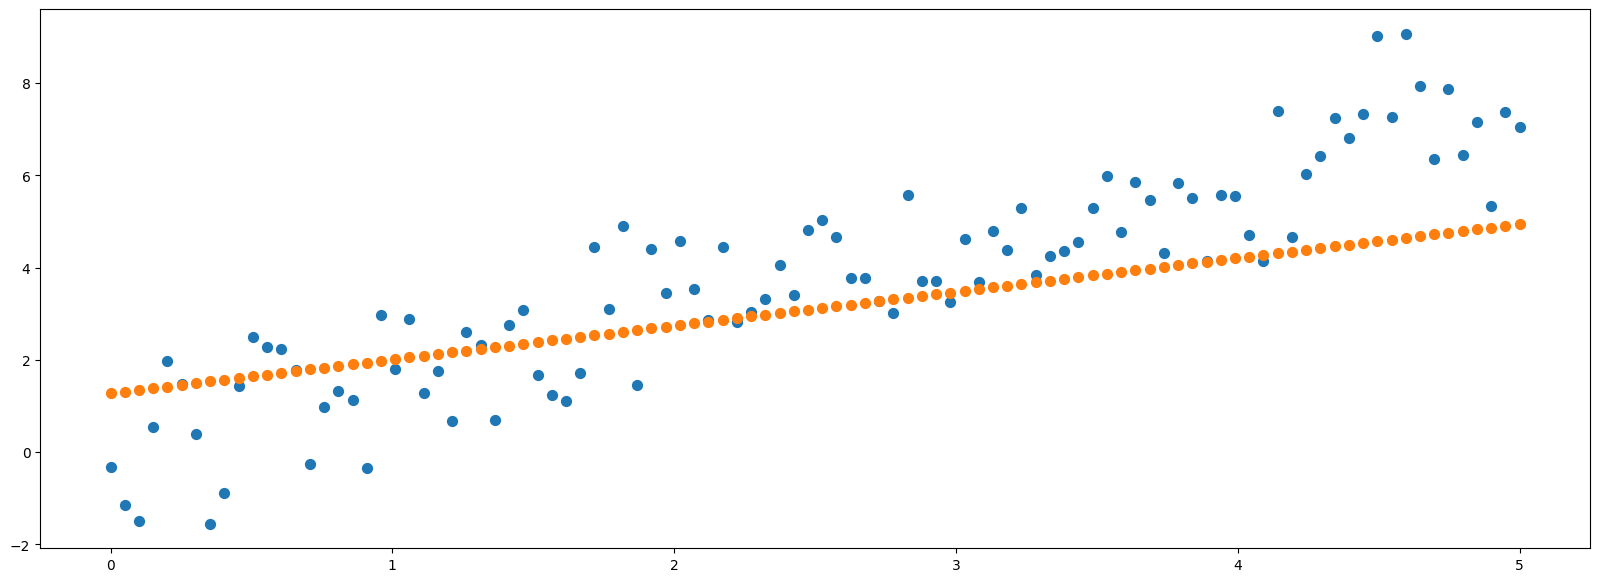

In [238]:
import matplotlib.pyplot as plt

y_pred = X @ W + b

plt.figure(figsize=(20, 7))
plt.scatter(X.data[:, 0], Y.data, s=50)

plt.scatter(X.data[:, 0], y_pred.data, s=50)
plt.show()